# 4.1 Timing and Scaling Analysis

Test the effect of:
1. Cheat-on-close (timing fix)
2. Drawdown scaling
3. Confidence weighting

**Hypothesis**: The remaining gap between simple backtest (+111%) and backtrader (-32%) is due to DD scaling reducing position sizes after early losses.

In [6]:
import sys
sys.path.insert(0, '.')

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

logging.basicConfig(level=logging.WARNING, format='%(levelname)s - %(message)s')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [17]:
from trading.bt_runner import run_backtest

MODEL_PATH = Path('data/model_simple_returns.pt')
DATA_DIR = Path('data')
START_DATE = '2024-10-22'
END_DATE = '2025-12-18'
INITIAL_CASH = 100_000

## Test 1: DD Scaling and Confidence Effects

In [18]:
configs = [
    {"name": "A. DD scaling + Confidence", "use_dd_scaling": True, "use_confidence": True},
    {"name": "B. DD scaling only", "use_dd_scaling": True, "use_confidence": False},
    {"name": "C. Confidence only", "use_dd_scaling": False, "use_confidence": True},
    {"name": "D. Neither (pure signal)", "use_dd_scaling": False, "use_confidence": False},
]

print(f"Testing {len(configs)} configurations...")

Testing 4 configurations...


In [19]:
%%time

results = []

for cfg in configs:
    print(f"\nRunning: {cfg['name']}...")
    
    res = run_backtest(
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=cfg['use_dd_scaling'],
        use_confidence=cfg['use_confidence'],
        news_only=True,
        cheat_on_close=True,  # Always use correct timing
    )
    
    print(f"  Return={res.total_return*100:+.1f}%, Sharpe={res.sharpe_ratio:.2f}, MaxDD={res.max_drawdown*100:.1f}%")
    
    results.append({
        'name': cfg['name'],
        'dd_scaling': cfg['use_dd_scaling'],
        'confidence': cfg['use_confidence'],
        'return': res.total_return,
        'sharpe': res.sharpe_ratio,
        'max_dd': res.max_drawdown,
        'n_trades': res.n_trades,
        'final_value': res.final_value,
    })


Running: A. DD scaling + Confidence...


RuntimeError: Error(s) in loading state_dict for MultiBranchRanker:
	size mismatch for fund_encoder.0.weight: copying a param with shape torch.Size([96, 19]) from checkpoint, the shape in current model is torch.Size([64, 19]).
	size mismatch for fund_encoder.0.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fund_encoder.3.weight: copying a param with shape torch.Size([32, 96]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for price_encoder.0.weight: copying a param with shape torch.Size([48, 9]) from checkpoint, the shape in current model is torch.Size([32, 9]).
	size mismatch for price_encoder.0.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for price_encoder.3.weight: copying a param with shape torch.Size([16, 48]) from checkpoint, the shape in current model is torch.Size([16, 32]).
	size mismatch for news_encoder.0.weight: copying a param with shape torch.Size([192, 768]) from checkpoint, the shape in current model is torch.Size([128, 768]).
	size mismatch for news_encoder.0.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for news_encoder.3.weight: copying a param with shape torch.Size([32, 192]) from checkpoint, the shape in current model is torch.Size([32, 128]).

In [10]:
# Results summary
results_df = pd.DataFrame(results)
results_df['return_pct'] = results_df['return'] * 100
results_df['max_dd_pct'] = results_df['max_dd'] * 100

print("="*80)
print("DD SCALING AND CONFIDENCE EFFECTS")
print("="*80)
print()
print(results_df[['name', 'return_pct', 'sharpe', 'max_dd_pct', 'n_trades']].to_string(index=False))
print()

# Analysis
best_idx = results_df['sharpe'].idxmax()
best = results_df.loc[best_idx]
print(f"Best by Sharpe: {best['name']}")
print(f"  Sharpe={best['sharpe']:.2f}, Return={best['return_pct']:.1f}%")

DD SCALING AND CONFIDENCE EFFECTS

                      name  return_pct    sharpe  max_dd_pct  n_trades
A. DD scaling + Confidence   87.675382  0.689600   69.053701       946
        B. DD scaling only   -8.023140 -0.452340   40.220402       945
        C. Confidence only   85.632385  0.685426   68.985213       946
  D. Neither (pure signal)   85.632385  0.685426   68.985213       946

Best by Sharpe: A. DD scaling + Confidence
  Sharpe=0.69, Return=87.7%


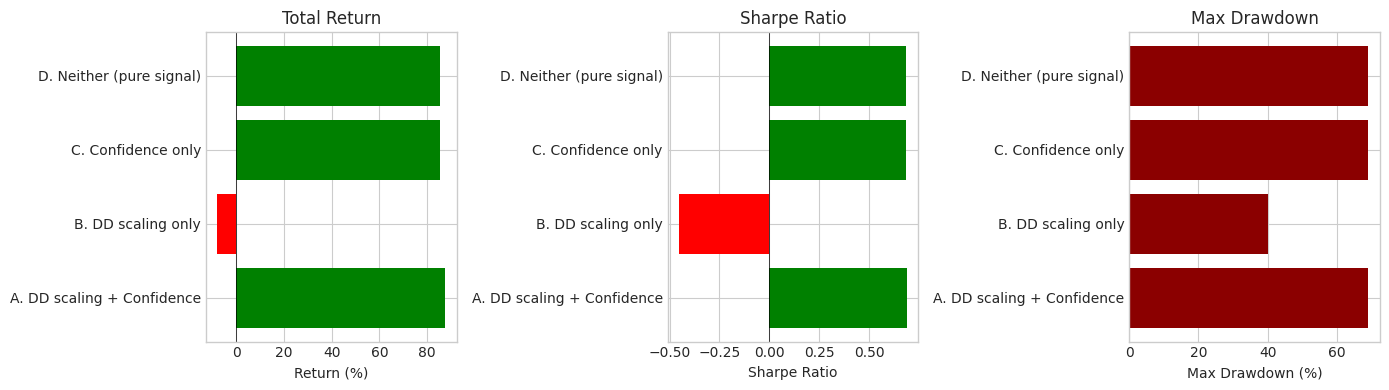

In [11]:
# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Returns
ax = axes[0]
colors = ['green' if x > 0 else 'red' for x in results_df['return_pct']]
ax.barh(results_df['name'], results_df['return_pct'], color=colors)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Return (%)')
ax.set_title('Total Return')

# Sharpe
ax = axes[1]
colors = ['green' if x > 0 else 'red' for x in results_df['sharpe']]
ax.barh(results_df['name'], results_df['sharpe'], color=colors)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio')

# Max DD
ax = axes[2]
ax.barh(results_df['name'], results_df['max_dd_pct'], color='darkred')
ax.set_xlabel('Max Drawdown (%)')
ax.set_title('Max Drawdown')

plt.tight_layout()
plt.show()

## Test 2: Timing Comparison (for reference)

In [12]:
# Compare COC on vs off with pure signal (no DD scaling, no confidence)
timing_configs = [
    {"name": "Wrong timing (next-bar)", "cheat_on_close": False},
    {"name": "Correct timing (COC)", "cheat_on_close": True},
]

timing_results = []

for cfg in timing_configs:
    print(f"Running: {cfg['name']}...")
    
    res = run_backtest(
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,  # Pure signal
        use_confidence=False,
        news_only=True,
        cheat_on_close=cfg['cheat_on_close'],
    )
    
    print(f"  Return={res.total_return*100:+.1f}%, Sharpe={res.sharpe_ratio:.2f}")
    timing_results.append({'name': cfg['name'], 'return': res.total_return, 'sharpe': res.sharpe_ratio})

print()
print("Timing Impact (pure signal, no scaling):")
for r in timing_results:
    print(f"  {r['name']}: Return={r['return']*100:+.1f}%, Sharpe={r['sharpe']:.2f}")

Running: Wrong timing (next-bar)...
  Return=-25.0%, Sharpe=-0.13
Running: Correct timing (COC)...
  Return=+85.6%, Sharpe=0.69

Timing Impact (pure signal, no scaling):
  Wrong timing (next-bar): Return=-25.0%, Sharpe=-0.13
  Correct timing (COC): Return=+85.6%, Sharpe=0.69


## Summary

**Expected Results:**
- Simple backtest (log returns, no clip): Sharpe ~4.1, Return +6446%
- Simple backtest (simple returns): Sharpe ~1.3, Return +111%
- Backtrader with COC + no scaling: Should approach simple backtest results
- Backtrader without COC: Sharpe ~0, massive losses

**Key Findings:**
1. Timing (COC) is critical - fixes the 1-day lag
2. DD scaling may hurt more than help if it locks in losses
3. Confidence weighting effect TBD

## Test 3: Fee Impact

Test with zero fees to isolate the fee drag from other factors.

In [5]:
from trading.config import TradingConfig, StrategyConfig, DEFAULT_CONFIG
from dataclasses import replace

# Create zero-fee config
zero_fee_strategy = replace(DEFAULT_CONFIG.strategy, fee_per_share=0.0)
zero_fee_config = replace(DEFAULT_CONFIG, strategy=zero_fee_strategy)

fee_configs = [
    {"name": "With fees ($0.003/share)", "config": DEFAULT_CONFIG},
    {"name": "Zero fees", "config": zero_fee_config},
]

fee_results = []

for cfg in fee_configs:
    print(f"Running: {cfg['name']}...")
    
    res = run_backtest(
        config=cfg['config'],
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,  # Pure signal
        use_confidence=False,
        news_only=True,
        cheat_on_close=True,
    )
    
    print(f"  Return={res.total_return*100:+.1f}%, Sharpe={res.sharpe_ratio:.2f}")
    fee_results.append({'name': cfg['name'], 'return': res.total_return, 'sharpe': res.sharpe_ratio, 'max_dd': res.max_drawdown})

print()
print("Fee Impact:")
for r in fee_results:
    print(f"  {r['name']}: Return={r['return']*100:+.1f}%, Sharpe={r['sharpe']:.2f}")

Running: With fees ($0.003/share)...
  Return=+85.6%, Sharpe=0.69
Running: Zero fees...
  Return=+102.4%, Sharpe=0.71

Fee Impact:
  With fees ($0.003/share): Return=+85.6%, Sharpe=0.69
  Zero fees: Return=+102.4%, Sharpe=0.71
